In [0]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix
import time
import datetime
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn import preprocessing
%matplotlib inline

Using TensorFlow backend.


## Question 1: Load


### Downloading Data Programmatically

In [0]:
"""
Data exists at: https://github.com/CapitalOneRecruiting/DS/raw/master/transactions.zip
"""

#downloading the file
!wget -c https://github.com/CapitalOneRecruiting/DS/raw/master/transactions.zip


--2020-03-30 11:52:42--  https://github.com/CapitalOneRecruiting/DS/raw/master/transactions.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/CapitalOneRecruiting/DS/master/transactions.zip [following]
--2020-03-30 11:52:42--  https://raw.githubusercontent.com/CapitalOneRecruiting/DS/master/transactions.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30522086 (29M) [application/zip]
Saving to: ‘transactions.zip’

transactions.zip    100%[===================>]  29.11M   157MB/s    in 0.2s    

2020-03-30 11:52:43 (157 MB/s) - ‘transactions.zip’ saved [30522086/30522086]



In [0]:
# extracting the zip file in the current directory
import zipfile

with zipfile.ZipFile("/content/transactions.zip") as zf:
  zf.extractall()
  zf.close()

In [0]:
# lets preview the file
f = open("/content/transactions.txt", "r")
i=0
for elem in f:
  print(elem)
  i+=1
  if i>5:
    break
f.close()

{"accountNumber": "737265056", "customerId": "737265056", "creditLimit": 5000.0, "availableMoney": 5000.0, "transactionDateTime": "2016-08-13T14:27:32", "transactionAmount": 98.55, "merchantName": "Uber", "acqCountry": "US", "merchantCountryCode": "US", "posEntryMode": "02", "posConditionCode": "01", "merchantCategoryCode": "rideshare", "currentExpDate": "06/2023", "accountOpenDate": "2015-03-14", "dateOfLastAddressChange": "2015-03-14", "cardCVV": "414", "enteredCVV": "414", "cardLast4Digits": "1803", "transactionType": "PURCHASE", "echoBuffer": "", "currentBalance": 0.0, "merchantCity": "", "merchantState": "", "merchantZip": "", "cardPresent": false, "posOnPremises": "", "recurringAuthInd": "", "expirationDateKeyInMatch": false, "isFraud": false}

{"accountNumber": "737265056", "customerId": "737265056", "creditLimit": 5000.0, "availableMoney": 5000.0, "transactionDateTime": "2016-10-11T05:05:54", "transactionAmount": 74.51, "merchantName": "AMC #191138", "acqCountry": "US", "mercha

we see that the data is smooth enough to be read directly by pandas.

In [0]:
# converting the json file to dataframe

data = pd.read_json("/content/transactions.txt", lines=True)
data.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,True,,,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,0.0,,,,True,,,False,False


In [0]:
# releasing from disk
import os
os.remove("/content/transactions.txt")
os.remove("/content/transactions.zip")

### Description and Structure of Data

In [0]:
#basic summary of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
accountNumber               786363 non-null int64
customerId                  786363 non-null int64
creditLimit                 786363 non-null int64
availableMoney              786363 non-null float64
transactionDateTime         786363 non-null object
transactionAmount           786363 non-null float64
merchantName                786363 non-null object
acqCountry                  786363 non-null object
merchantCountryCode         786363 non-null object
posEntryMode                786363 non-null object
posConditionCode            786363 non-null object
merchantCategoryCode        786363 non-null object
currentExpDate              786363 non-null object
accountOpenDate             786363 non-null object
dateOfLastAddressChange     786363 non-null object
cardCVV                     786363 non-null int64
enteredCVV                  786363 non-null int64
cardLast4Digits          

In [0]:
# formally getting total enteries in the dataset
len(data)

786363

So there are 786363 records in the file

In [0]:
print("There are {} fields/columns of each record in the dataset".format(len(data.columns)))

There are 29 fields/columns of each record in the dataset


### Additional statistics of each column

In [0]:
# getting some numbers for the numerical columns in the dataset
data.describe()

,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,cardCVV,enteredCVV,cardLast4Digits,currentBalance
count,7.863630e+05,7.863630e+05,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000
mean,5.372326e+08,5.372326e+08,10759.464459,6250.725369,136.985791,544.467338,544.183857,4757.417799,4508.739089
std,2.554211e+08,2.554211e+08,11636.174890,8880.783989,147.725569,261.524220,261.551254,2996.583810,6457.442068
min,1.000881e+08,1.000881e+08,250.000000,-1005.630000,0.000000,100.000000,0.000000,0.000000,0.000000
25%,3.301333e+08,3.301333e+08,5000.000000,1077.420000,33.650000,310.000000,310.000000,2178.000000,689.910000
50%,5.074561e+08,5.074561e+08,7500.000000,3184.860000,87.900000,535.000000,535.000000,4733.000000,2451.760000
75%,7.676200e+08,7.676200e+08,15000.000000,7500.000000,191.480000,785.000000,785.000000,7338.000000,5291.095000
max,9.993896e+08,9.993896e+08,50000.000000,50000.000000,2011.540000,998.000000,998.000000,9998.000000,47498.810000


This states the maximum and minimum of each numeric column. For some columns (eg. accountnumber, customerID does not realy make sense, so precaution must be observed using these numbers.

In [0]:
# for getting null values
data.isnull().sum()

accountNumber               0
customerId                  0
creditLimit                 0
availableMoney              0
transactionDateTime         0
transactionAmount           0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
currentExpDate              0
accountOpenDate             0
dateOfLastAddressChange     0
cardCVV                     0
enteredCVV                  0
cardLast4Digits             0
transactionType             0
echoBuffer                  0
currentBalance              0
merchantCity                0
merchantState               0
merchantZip                 0
cardPresent                 0
posOnPremises               0
recurringAuthInd            0
expirationDateKeyInMatch    0
isFraud                     0
dtype: int64

So there are no null values in the dataframe (in the numeric columns). but we need to check for the 'object' type columns to see if they have null values.




Agrregating some categorical data to perform further analysis:

In [0]:
# data with type==object
data_obj = data.select_dtypes(include=['object', "bool"])
data_obj.head()

,transactionDateTime,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,transactionType,echoBuffer,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,2016-08-13T14:27:32,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,PURCHASE,,,,,False,,,False,False
1,2016-10-11T05:05:54,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,PURCHASE,,,,,True,,,False,False
2,2016-11-08T09:18:39,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,PURCHASE,,,,,False,,,False,False
3,2016-12-10T02:14:50,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,PURCHASE,,,,,False,,,False,False
4,2016-03-24T21:04:46,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,PURCHASE,,,,,True,,,False,False


In [0]:
data_obj.applymap(lambda x: x == '').sum()

transactionDateTime              0
merchantName                     0
acqCountry                    4562
merchantCountryCode            724
posEntryMode                  4054
posConditionCode               409
merchantCategoryCode             0
currentExpDate                   0
accountOpenDate                  0
dateOfLastAddressChange          0
transactionType                698
echoBuffer                  786363
merchantCity                786363
merchantState               786363
merchantZip                 786363
cardPresent                      0
posOnPremises               786363
recurringAuthInd            786363
expirationDateKeyInMatch         0
isFraud                          0
dtype: int64

So there are a lot of Null values in the object columns. Since they are categorical columns, they would be treated as categories.

Dealing with each of these columns individually:

1. merchantName

In [0]:
data_obj["merchantName"].value_counts()

Uber                             25613
Lyft                             25523
oldnavy.com                      16992
staples.com                      16980
alibaba.com                      16959
                                 ...  
Sprint Communications #561941        2
Boost Mobile #104815                 2
Curves #849125                       1
EZ Wireless #149871                  1
TMobile Wireless #602341             1
Name: merchantName, Length: 2490, dtype: int64

A lot of catrgories. Text processing can be done on this column to give meaningful results.

2. acqCountry

In [0]:
data_obj["acqCountry"].value_counts()

US     774709
         4562
MEX      3130
CAN      2424
PR       1538
Name: acqCountry, dtype: int64

3. merchantCountryCode

In [0]:
data_obj["merchantCountryCode"].value_counts()

US     778511
MEX      3143
CAN      2426
PR       1559
          724
Name: merchantCountryCode, dtype: int64

4. posEntryMode

In [0]:
data_obj["posEntryMode"].value_counts()

05    315035
09    236481
02    195934
90     19576
80     15283
        4054
Name: posEntryMode, dtype: int64

5. posConditionCode

In [0]:
data_obj["posConditionCode"].value_counts()

01    628787
08    149634
99      7533
         409
Name: posConditionCode, dtype: int64

6. merchantCategoryCode

In [0]:
data_obj["merchantCategoryCode"].value_counts()

online_retail           202156
fastfood                112138
entertainment            80098
food                     75490
online_gifts             66238
rideshare                51136
hotels                   34097
fuel                     23910
subscriptions            22901
auto                     21651
health                   19092
personal care            18964
airline                  15412
mobileapps               14990
online_subscriptions     11067
furniture                 7432
food_delivery             6000
gym                       2209
cable/phone               1382
Name: merchantCategoryCode, dtype: int64

7. transactionType

In [0]:
data_obj["transactionType"].value_counts()

PURCHASE                745193
REVERSAL                 20303
ADDRESS_VERIFICATION     20169
                           698
Name: transactionType, dtype: int64

8. echoBuffer, merchantCity, merchantState, posOnPremises, recurringAuthInd.

All are empty as shown below. These columns can be dropped.

In [0]:
print(data_obj["echoBuffer"].value_counts(), "\n",\
    data_obj["merchantCity"].value_counts(), "\n",\
    data_obj["merchantState"].value_counts(), "\n",\
    data_obj["posOnPremises"].value_counts(), "\n",\
    data_obj["recurringAuthInd"].value_counts())

    786363
Name: echoBuffer, dtype: int64 
     786363
Name: merchantCity, dtype: int64 
     786363
Name: merchantState, dtype: int64 
     786363
Name: posOnPremises, dtype: int64 
     786363
Name: recurringAuthInd, dtype: int64


In [0]:
data = data.drop(["echoBuffer", "merchantCity", "merchantState", "posOnPremises", "recurringAuthInd"], axis=1)

For the Boolean columns, lets check the distributions

In [0]:
print(data_obj["cardPresent"].value_counts(), "\n",\
 data_obj["expirationDateKeyInMatch"].value_counts(), "\n",\
 data_obj["isFraud"].value_counts())

False    433495
True     352868
Name: cardPresent, dtype: int64 
 False    785320
True       1043
Name: expirationDateKeyInMatch, dtype: int64 
 False    773946
True      12417
Name: isFraud, dtype: int64


In [0]:
# clearning the disk
del data_obj

Dealing with the time series data now:

1. transactionDateTime
2. currentExpDate	
3. accountOpenDate	
4. dateOfLastAddressChange

In [0]:
# for transactionDateTime
converted_transactionDateTime = list(map(datetime.datetime.strptime, data["transactionDateTime"], len(data["transactionDateTime"])*['%Y-%m-%dT%H:%M:%S']))
data["transactionDateTime"] = converted_transactionDateTime
print("Start and end dates of the recordings are {} and {}".format(min(converted_transactionDateTime), max(converted_transactionDateTime)))

Start and end dates of the recordings are 2016-01-01 00:01:02 and 2016-12-30 23:59:45


In [0]:
converted_expdate = list(map(datetime.datetime.strptime, data["currentExpDate"], len(data["currentExpDate"])*['%m/%Y']))
data["currentExpDate"] = converted_expdate
print("Start and end dates of the recordings are {} and {}".format(min(converted_expdate).strftime('%m/%Y'), max(converted_expdate).strftime('%m/%Y')))

Start and end dates of the recordings are 12/2019 and 08/2033


In [0]:
converted_accountOpenDate = list(map(datetime.datetime.strptime, data["accountOpenDate"], len(data["accountOpenDate"])*['%Y-%m-%d']))
data["accountOpenDate"] = converted_accountOpenDate
print("Start and end dates of the recordings are {} and {}".format(min(converted_accountOpenDate).strftime('%Y-%m-%d'), max(converted_accountOpenDate).strftime('%Y-%m-%d')))

Start and end dates of the recordings are 1989-08-22 and 2015-12-31


In [0]:
converted_LastAddressChange = list(map(datetime.datetime.strptime, data["dateOfLastAddressChange"], len(data["dateOfLastAddressChange"])*['%Y-%m-%d']))
data["dateOfLastAddressChange"] = converted_LastAddressChange
print("Start and end dates of the recordings are {} and {}".format(min(converted_LastAddressChange).strftime('%Y-%m-%d'), max(converted_LastAddressChange).strftime('%Y-%m-%d')))

Start and end dates of the recordings are 1989-08-22 and 2016-12-30


## Question 2: Plot

### Plot a histogram of the processed amounts of each transaction, the transactionAmount column

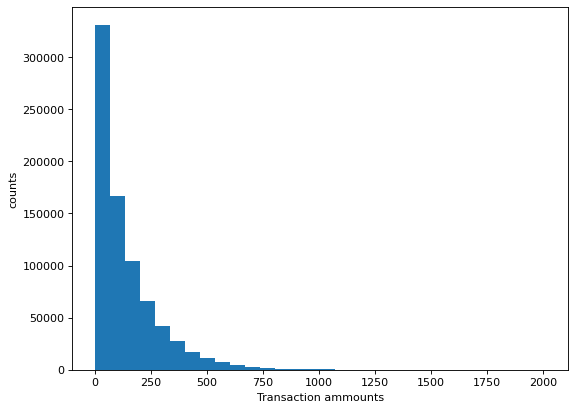

In [0]:
# using matplotlib's histogram function 
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
histogram, bin_list, _ = plt.hist(data["transactionAmount"], bins=30)
plt.xlabel("Transaction ammounts")
plt.ylabel("counts")
plt.show()

### Report any structure you find and any hypotheses you have about that structure.

As we see the distribution is highly skewed to the right. A logrithmic transformation might work here but should be tested.

In [0]:
bin_list

array([   0.        ,   67.05133333,  134.10266667,  201.154     ,
        268.20533333,  335.25666667,  402.308     ,  469.35933333,
        536.41066667,  603.462     ,  670.51333333,  737.56466667,
        804.616     ,  871.66733333,  938.71866667, 1005.77      ,
       1072.82133333, 1139.87266667, 1206.924     , 1273.97533333,
       1341.02666667, 1408.078     , 1475.12933333, 1542.18066667,
       1609.232     , 1676.28333333, 1743.33466667, 1810.386     ,
       1877.43733333, 1944.48866667, 2011.54      ])

In [0]:
# removing 0 from the scale as log(0)=infinity and finding the minimum value for start of bins

temp_list = list(filter(lambda a: a != 0., data["transactionAmount"]))
min(temp_list)

0.01

Transforming with log base 10

Text(0, 0.5, 'counts')

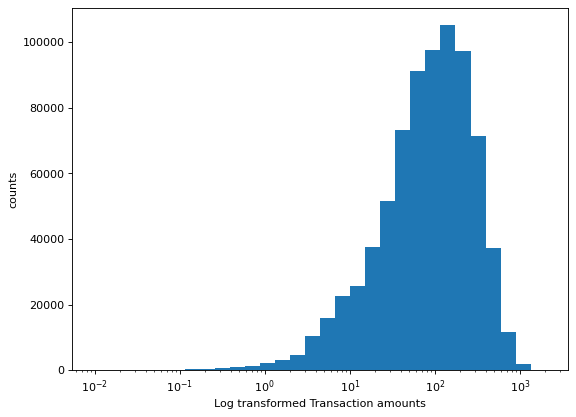

In [0]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(temp_list, bins=np.logspace(np.log10(0.01),np.log10(bin_list[-1]),len(bin_list)))
plt.xscale('log')
plt.xlabel("Log transformed Transaction amounts")
plt.ylabel("counts")


Transforming with natural log

Text(0, 0.5, 'counts')

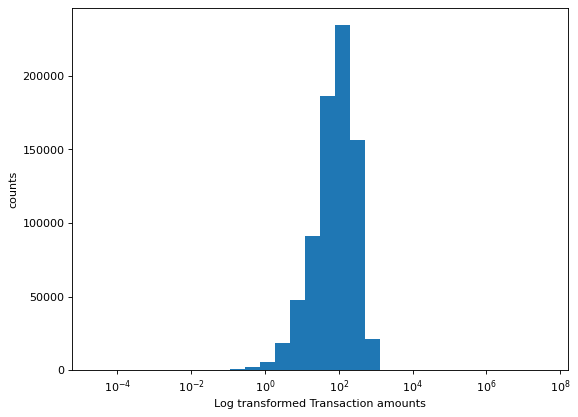

In [0]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(temp_list, bins=np.logspace(np.log(0.01),np.log(bin_list[-1]),len(bin_list)))
plt.xscale('log', )
plt.xlabel("Log transformed Transaction amounts")
plt.ylabel("counts")

Natural log transformation bring the distribution more close to a gaussian distribution.

## Question 3: Data Wrangling - Duplicate Transactions

### Can you programmatically identify reversed and multi-swipe transactions?

Firstly, lets define duplicated transactions. For a duplicated transaction all of the following fields to stay the same:

"accountNumber", "customerId", "transactionAmount", "merchantName", "acqCountry", "merchantCountryCode", "merchantCategoryCode", "cardCVV", "cardLast4Digits"

We consider 2 additional fields "transactionDateTime" and "transactionType" to identify the 2 types.

Making a seperate df for this (some fields like creditLimit, availabeMoney, posEntryMode, dateOfLastAddressChange, currentBalance, cardPresent etc have been left out).

In [0]:
"""
Here we are defining a new dataset with the below features:
1. Only the fields necessary for duplicate identification and its subdivision.
2. The transactions are duplicates i.e. all fields are the same except transaction time and transaction type.
"""

data_for_dupl = data[["accountNumber", "customerId", "transactionDateTime", "transactionAmount", "merchantName", "acqCountry", "merchantCountryCode",\
                     "merchantCategoryCode", "transactionType", "cardCVV", "cardLast4Digits"]]

data_for_dupl = data_for_dupl.loc[data_for_dupl.iloc[:,[0,1,3,4,5,6,7,9]].duplicated(keep=False)].reset_index(drop=True)
data_for_dupl.head()

,accountNumber,customerId,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,merchantCategoryCode,transactionType,cardCVV,cardLast4Digits
0,737265056,737265056,2016-11-08 09:18:39,7.47,Play Store,US,US,mobileapps,PURCHASE,486,767
1,737265056,737265056,2016-12-10 02:14:50,7.47,Play Store,US,US,mobileapps,PURCHASE,486,767
2,830329091,830329091,2016-12-07 16:34:04,40.75,GreenCook,US,US,food_delivery,PURCHASE,885,3143
3,830329091,830329091,2016-12-14 10:00:35,40.75,GreenCook,US,US,food_delivery,PURCHASE,885,3143
4,830329091,830329091,2016-12-20 18:38:23,40.75,GreenCook,US,US,food_delivery,PURCHASE,885,3143


For the duplicated entries, the above features should remain the same. But precaution must be observed as customers could have bought the same things twice.

Lets deal with **Reversal** First. Since we do not concern ourselves with the original transaction (for which we have the reversal) it makes our task easy.

In [0]:
# we only take our the transaction type that is a reversal

reversal_dup = data_for_dupl.loc[data_for_dupl["transactionType"]=="REVERSAL"].reset_index(drop=True)
reversal_dup.head()

,accountNumber,customerId,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,merchantCategoryCode,transactionType,cardCVV,cardLast4Digits
0,574788567,574788567,2016-05-24 01:38:03,215.13,Convenient Tire,US,US,auto,REVERSAL,206,8522
1,924729945,924729945,2016-10-19 14:01:45,168.57,discount.com,US,US,online_retail,REVERSAL,205,9459
2,984504651,984504651,2016-01-16 09:53:15,450.74,Planet Fitness #849960,US,US,health,REVERSAL,640,8332
3,984504651,984504651,2016-01-25 20:39:15,81.73,AMC #724446,US,US,entertainment,REVERSAL,640,8332
4,984504651,984504651,2016-02-04 00:14:42,83.64,1st Sandwitch Bar #801388,US,US,food,REVERSAL,640,8332


Now lets deal with **multiple swipes transactions**.


In [0]:
"""
To identify multiple swipe we identify a logical vector which turn to be true if:

1. the transaction type is Purchase
2. time different between the transaction before it is less than 5 min (300 seconds)

Note: The first transaction in the Multiple Swipe transaction is considered valid so logical vector will be false for that.

"""


mul_swipe_bool = data_for_dupl.loc[data_for_dupl["transactionType"]=="PURCHASE"].groupby(["accountNumber", "customerId", "transactionAmount", "merchantName", \
                                       "acqCountry", "merchantCountryCode", "merchantCategoryCode", "cardCVV", "cardLast4Digits"])\
                                       .transactionDateTime.apply(lambda x: x.diff().dt.seconds < 300)

In [0]:
# using the logical vector to get the data frame

mul_swipe_dup = data_for_dupl.loc[data_for_dupl["transactionType"]=="PURCHASE"][list(mul_swipe_bool)].reset_index(drop=True)
mul_swipe_dup.head()

,accountNumber,customerId,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,merchantCategoryCode,transactionType,cardCVV,cardLast4Digits
0,984504651,984504651,2016-03-12 06:34:29,118.52,AMC #706324,US,US,entertainment,PURCHASE,640,8332
1,984504651,984504651,2016-03-12 06:36:41,118.52,AMC #706324,US,US,entertainment,PURCHASE,640,8332
2,984504651,984504651,2016-03-18 13:57:04,26.71,Planet Fitness #692929,US,US,health,PURCHASE,640,8332
3,984504651,984504651,2016-04-08 22:21:11,43.21,WSC #994275,US,US,health,PURCHASE,640,8332
4,984504651,984504651,2016-05-07 07:32:54,23.82,Golds Gym #846582,US,US,health,PURCHASE,640,8332


### What total number of transactions and total dollar amount do you estimate for the reversed transactions? For the multi-swipe transactions? 

In [0]:
len(reversal_dup)

18359

In [0]:
sum(reversal_dup['transactionAmount'])

2669859.55999999

***So there are 18359 duplicated Reversal records and about $2,669,860 in total dollar amount for Reversal***

For Multiple Swipes:

In [0]:
len(mul_swipe_dup)

7600

In [0]:
sum(mul_swipe_dup['transactionAmount'])

1107378.5299999937

***So there are 7600 duplicated Multiple Swipe records and about $1,107,379 in total dollar amount for multiple swipes ***

### Did you find anything interesting about either kind of transaction?

So there are 18359 duplicated Reversal records

But we saw above that there are 20303 total Reversal records. So lets see what are those other entries

In [0]:
data.loc[~data.iloc[:,[0,1,5,6,7,8,11,15,17]].duplicated(keep=False)].loc[data["transactionType"]=="REVERSAL"]

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,merchantZip,cardPresent,expirationDateKeyInMatch,isFraud
73,574788567,574788567,2500,2432.72,2016-10-07 10:23:57,3.87,Eazy Repair,US,US,05,01,auto,2022-10-01,2015-10-13,2015-10-13,579,579,4219,REVERSAL,67.28,,True,False,False
309,984504651,984504651,50000,19448.36,2016-03-29 07:45:09,36.97,Walgreens #310950,US,US,02,01,health,2021-09-01,2015-07-27,2016-03-26,640,640,8332,REVERSAL,30551.64,,False,False,False
329,984504651,984504651,50000,17158.66,2016-04-04 16:01:08,288.77,WSC #794510,US,US,05,01,health,2020-02-01,2015-07-27,2016-03-26,640,640,8332,REVERSAL,32841.34,,False,False,False
1151,114896048,114896048,15000,2616.81,2016-05-10 20:05:42,10.51,Uber,US,US,05,01,rideshare,2028-01-01,2015-12-19,2015-12-19,773,773,8915,REVERSAL,12383.19,,False,False,False
1254,114896048,114896048,15000,2652.85,2016-07-20 20:28:26,7.27,target.com,US,US,05,01,online_retail,2022-04-01,2015-12-19,2016-06-10,773,773,8915,REVERSAL,12347.15,,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785516,841351704,841351704,50000,24777.68,2016-11-26 19:02:41,121.42,Dallas Journal,US,US,02,08,subscriptions,2028-04-01,2015-12-17,2015-12-17,651,651,7831,REVERSAL,25222.32,,False,False,False
785833,428856030,428856030,250,113.29,2016-03-26 02:12:47,47.22,Hilton Hotels #863711,US,US,09,01,hotels,2026-03-01,2009-08-17,2009-08-17,990,990,7660,REVERSAL,136.71,,True,False,False
786024,205026043,205026043,5000,692.68,2016-11-02 22:44:38,67.48,Arbys #384282,US,US,09,01,fastfood,2020-02-01,2008-04-15,2008-04-15,198,198,3931,REVERSAL,4307.32,,True,False,False
786106,899818521,899818521,2500,968.33,2016-09-29 02:04:32,10.05,cheapfast.com,US,US,02,99,online_retail,2031-02-01,2013-06-15,2013-06-15,421,421,3424,REVERSAL,1531.67,,False,False,False


So the remaining 1944 Reversal records are not exactly duplicate entries. The may be partial reversal, and other fields may differ.

Lets see an example of this:

In [0]:
data.loc[(data["accountNumber"]==984504651) & (data["merchantName"]=="WSC #794510")]

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,merchantZip,cardPresent,expirationDateKeyInMatch,isFraud
292,984504651,984504651,50000,22873.49,2016-03-24 04:03:54,362.10,WSC #794510,US,US,05,01,health,2020-02-01,2015-07-27,2015-07-27,640,640,8332,PURCHASE,27126.51,,False,False,False
329,984504651,984504651,50000,17158.66,2016-04-04 16:01:08,288.77,WSC #794510,US,US,05,01,health,2020-02-01,2015-07-27,2016-03-26,640,640,8332,REVERSAL,32841.34,,False,False,False
840,984504651,984504651,50000,34023.47,2016-11-13 01:22:41,304.40,WSC #794510,US,US,09,08,health,2020-12-01,2015-07-27,2016-10-19,640,640,8332,PURCHASE,15976.53,,True,False,False


So as we see in this example, the Reversal is only partial, 288.77, out of a total of $362.10.

So we shall not consider them Duplicated. 

## Question 4: Model

### Fraud is a problem for any bank. Fraud can take many forms, whether it is someone stealing a single credit card, to large batches of stolen credit card numbers being used on the web, or even a mass compromise of credit card numbers stolen from a merchant via tools like credit card skimming devices.

In [0]:
data.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,merchantZip,cardPresent,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,2023-06-01,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,,False,False,False
1,737265056,737265056,5000,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,2024-02-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,,True,False,False
2,737265056,737265056,5000,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,,False,False,False
3,737265056,737265056,5000,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,,False,False,False
4,830329091,830329091,5000,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,2029-10-01,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,,True,False,False


In [0]:
iub

NameError: ignored

Copying the dataset for model so that we do not change the original and removing cardlast4Digits feature as the those numbers are randomized

In [0]:
df_model = data.drop([ "cardLast4Digits"], axis=1)

Feature Engineering:

As we look through the features that we have, we can create some useful features from transactionDateTime.

1. transaction_count_acc: The number of transactions conducted by the accountNumber in the given year. ***Our data shows almost a 1 to 1 mapping between customerID and accountNumber so the customerID could have been used as well.***

2. timesince_last_transaction: [in days] This is the time in days past since the previous transaction from the account. For simplistic purposes, we shall mark the starting time as the mean of all accountholder previous transaction time.

In [0]:
df_model["transaction_count_acc"] = df_model.groupby("accountNumber").cumcount()
df_model["timesince_last_transac"] = df_model.groupby("accountNumber").transactionDateTime.apply(lambda x: x.diff().dt.days)
df_model.fillna(int(np.mean(df_model["timesince_last_transac"])+1), inplace=True)
df_model.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,transactionType,currentBalance,merchantZip,cardPresent,expirationDateKeyInMatch,isFraud,transaction_count_acc,timesince_last_transac
0,737265056,737265056,5000,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,2023-06-01,2015-03-14,2015-03-14,414,414,PURCHASE,0.0,,False,False,False,0,2.0
1,737265056,737265056,5000,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,2024-02-01,2015-03-14,2015-03-14,486,486,PURCHASE,0.0,,True,False,False,1,58.0
2,737265056,737265056,5000,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,PURCHASE,0.0,,False,False,False,2,28.0
3,737265056,737265056,5000,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,PURCHASE,0.0,,False,False,False,3,31.0
4,830329091,830329091,5000,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,2029-10-01,2015-08-06,2015-08-06,885,885,PURCHASE,0.0,,True,False,False,0,2.0


There is a special relationship between customers and the catergories they spend on and the merchants they visit. We develop some features for that:

Customer and Merchant:
1. cus_merch_transac_count: number of previous transactions conducted at the merchant.

2. cus_merch_transac_med: Median money spent at the merchant.

Customer and category:
1. cus_cat_transac_count: number of previous transactions in the category/

2. cus_merch_transac_avg: Median money spent in the specific category.

We used median as it is resistant to outliers.

In [0]:
df_model["cus_merch_transac_count"]=df_model.groupby(["customerId", "merchantName"]).cumcount()
df_model["cus_merch_transac_med"]=df_model.groupby(["customerId", "merchantName"])['transactionAmount'].transform("median")

df_model["cus_cat_transac_count"]=df_model.groupby(["customerId", "merchantCategoryCode"]).cumcount()
df_model["cus_cat_transac_med"]=df_model.groupby(["customerId", "merchantCategoryCode"])['transactionAmount'].transform("median")
df_model.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,transactionType,currentBalance,merchantZip,cardPresent,expirationDateKeyInMatch,isFraud,transaction_count_acc,timesince_last_transac,cus_merch_transac_count,cus_merch_transac_med,cus_cat_transac_count,cus_cat_transac_med
0,737265056,737265056,5000,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,2023-06-01,2015-03-14,2015-03-14,414,414,PURCHASE,0.0,,False,False,False,0,2.0,0,98.55,0,98.55
1,737265056,737265056,5000,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,2024-02-01,2015-03-14,2015-03-14,486,486,PURCHASE,0.0,,True,False,False,1,58.0,0,74.51,0,74.51
2,737265056,737265056,5000,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,PURCHASE,0.0,,False,False,False,2,28.0,0,7.47,0,7.47
3,737265056,737265056,5000,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,PURCHASE,0.0,,False,False,False,3,31.0,1,7.47,1,7.47
4,830329091,830329091,5000,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,2029-10-01,2015-08-06,2015-08-06,885,885,PURCHASE,0.0,,True,False,False,0,2.0,0,71.18,0,71.18


In [0]:
df_model["trans_over_mean_merch"] = df_model["transactionAmount"]/df_model.groupby(["merchantName"])['transactionAmount'].transform("mean")
df_model["trans_over_std_merch"] = df_model["transactionAmount"]/df_model.groupby(["merchantName"])['transactionAmount'].transform("std")

df_model["trans_over_mean_cat"] = df_model["transactionAmount"]/df_model.groupby(["merchantCategoryCode"])['transactionAmount'].transform("mean")
df_model["trans_over_std_cat"] = df_model["transactionAmount"]/df_model.groupby(["merchantCategoryCode"])['transactionAmount'].transform("std")

df_model["trans_over_mean_cus"] = df_model["transactionAmount"]/df_model.groupby(["customerId"])['transactionAmount'].transform("mean")
df_model["trans_over_std_cus"] = df_model["transactionAmount"]/df_model.groupby(["customerId"])['transactionAmount'].transform("std")

Another feature that could be developed is:
1. how many fraudulent transactions have been conducted from an account. This will show us if an account has been compromised.

2. how many fraudulent transactions have been conducted from a merchant. This will show us if a merchant has been compromised.

In [0]:
df_model["prev_Fraud_acc"] = data.groupby(["accountNumber"])['isFraud'].transform('sum')
df_model["prev_Fraud_merch"] = data.groupby(["merchantName"])['isFraud'].transform('sum')


Some features which might be useful:

1. Whether the entered CVV matches the card CVV. Then dropping the CVV.
2. Whether country match
3. Using date time features, taking the time difference between the transaction time and the rest may offer some insight. then dropping the dates.

In [0]:
df_model["cvv_match"] = df_model.apply(lambda x: x["cardCVV"]==x["enteredCVV"], axis=1)
df_model["country_match"] = df_model.apply(lambda x: x["acqCountry"]==x["merchantCountryCode"], axis=1)

In [0]:
df_model["datediff_exp"] = (df_model["currentExpDate"]-df_model["transactionDateTime"]).dt.days//30
df_model["datediff_acc"] = (df_model["transactionDateTime"]-df_model["accountOpenDate"]).dt.days//30
df_model["datediff_add"] = (df_model["transactionDateTime"]-df_model["dateOfLastAddressChange"]).dt.days//30

Assuming Fraud is only being conducted on transactiontype as PURCHASE so cutting down our data.

In [0]:
df_model = df_model.loc[df_model.transactionType=="PURCHASE"]

Dropping Unimportant features:

1. AccountNumber and CustomerID have been used above for some features but cannot be used for modeling.

2. Date and time features have been used for some features above. Could be used for more feature engineering, but we proceed further due to time constraints. 

3. MerchantCountry code and acqcountry was used for a logical vector feature. 

4. Dropping merchant name which was used above. Her the assumption is that certain locations of the merchant (assigned numbers) can be fraudulent not entire merchant.

5. Merchant Zip is dropped as it is an empty column

6. CardCVV and enteredCVV was used for matching feature and are now being dropped.

7. Transactiontype as only one type is left.

8. Merchant Category as we have already used for feature engineering

In [0]:
df_model = df_model.drop(["accountNumber", "customerId", "transactionDateTime", "currentExpDate", "dateOfLastAddressChange", "accountOpenDate", "cardCVV", "enteredCVV", \
                          "acqCountry", "merchantCountryCode", "merchantZip", "merchantName", 'transactionType', "merchantCategoryCode"], axis=1)
df_model.head()

,creditLimit,availableMoney,transactionAmount,posEntryMode,posConditionCode,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transaction_count_acc,timesince_last_transac,cus_merch_transac_count,cus_merch_transac_med,cus_cat_transac_count,cus_cat_transac_med,trans_over_mean_merch,trans_over_std_merch,trans_over_mean_cat,trans_over_std_cat,trans_over_mean_cus,trans_over_std_cus,prev_Fraud_acc,prev_Fraud_merch,cvv_match,country_match,datediff_exp,datediff_acc,datediff_add
0,5000,5000.0,98.55,02,01,0.0,False,False,False,0,2.0,0,98.55,0,98.55,0.676336,0.654610,0.673981,0.655354,2.096809,2.110799,0.0,512.0,True,True,82,17,17
1,5000,5000.0,74.51,09,01,0.0,True,False,False,1,58.0,0,74.51,0,74.51,0.514582,0.497311,0.510197,0.495961,1.585319,1.595897,0.0,20.0,True,True,88,19,19
2,5000,5000.0,7.47,09,01,0.0,False,False,False,2,28.0,0,7.47,0,7.47,1.273399,3.926232,1.279722,3.832968,0.158936,0.159997,0.0,0.0,True,True,106,20,20
3,5000,5000.0,7.47,09,01,0.0,False,False,False,3,31.0,1,7.47,1,7.47,1.273399,3.926232,1.279722,3.832968,0.158936,0.159997,0.0,0.0,True,True,105,21,21
4,5000,5000.0,71.18,02,01,0.0,True,False,False,0,2.0,0,71.18,0,71.18,0.515317,0.598171,0.488902,0.474981,0.663649,0.483884,0.0,1.0,True,True,164,7,7


Assuming posEntry and posConditionCode might offer some insights, we convert them into categories and one-hot vector features

In [0]:
for col in ['posEntryMode', "posConditionCode"]:
    df_model[col] = df_model[col].astype('category')
df_model = pd.get_dummies(df_model)

Label encoding our logical vectors and changing type to category:

1. cardPresent
2. expirationDateKeyInMatch
3. cvv_match
4. country_match
5. isFraud - our target vector

In [0]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_model["cardPresent"] = le.fit_transform(df_model["cardPresent"])
le = preprocessing.LabelEncoder()
df_model["expirationDateKeyInMatch"] = le.fit_transform(df_model["expirationDateKeyInMatch"])
le = preprocessing.LabelEncoder()
df_model["cvv_match"] = le.fit_transform(df_model["cvv_match"])
le = preprocessing.LabelEncoder()
df_model["isFraud"] = le.fit_transform(df_model["isFraud"])
le = preprocessing.LabelEncoder()
df_model["country_match"] = le.fit_transform(df_model["country_match"])

df_model.head()

,creditLimit,availableMoney,transactionAmount,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transaction_count_acc,timesince_last_transac,cus_merch_transac_count,cus_merch_transac_med,cus_cat_transac_count,cus_cat_transac_med,trans_over_mean_merch,trans_over_std_merch,trans_over_mean_cat,trans_over_std_cat,trans_over_mean_cus,trans_over_std_cus,prev_Fraud_acc,prev_Fraud_merch,cvv_match,country_match,datediff_exp,datediff_acc,datediff_add,posEntryMode_,posEntryMode_02,posEntryMode_05,posEntryMode_09,posEntryMode_80,posEntryMode_90,posConditionCode_,posConditionCode_01,posConditionCode_08,posConditionCode_99
0,5000,5000.0,98.55,0.0,0,0,0,0,2.0,0,98.55,0,98.55,0.676336,0.654610,0.673981,0.655354,2.096809,2.110799,0.0,512.0,1,1,82,17,17,0,1,0,0,0,0,0,1,0,0
1,5000,5000.0,74.51,0.0,1,0,0,1,58.0,0,74.51,0,74.51,0.514582,0.497311,0.510197,0.495961,1.585319,1.595897,0.0,20.0,1,1,88,19,19,0,0,0,1,0,0,0,1,0,0
2,5000,5000.0,7.47,0.0,0,0,0,2,28.0,0,7.47,0,7.47,1.273399,3.926232,1.279722,3.832968,0.158936,0.159997,0.0,0.0,1,1,106,20,20,0,0,0,1,0,0,0,1,0,0
3,5000,5000.0,7.47,0.0,0,0,0,3,31.0,1,7.47,1,7.47,1.273399,3.926232,1.279722,3.832968,0.158936,0.159997,0.0,0.0,1,1,105,21,21,0,0,0,1,0,0,0,1,0,0
4,5000,5000.0,71.18,0.0,1,0,0,0,2.0,0,71.18,0,71.18,0.515317,0.598171,0.488902,0.474981,0.663649,0.483884,0.0,1.0,1,1,164,7,7,0,1,0,0,0,0,0,1,0,0


In [0]:
for col in ['isFraud', 'expirationDateKeyInMatch', 'cardPresent', 'cvv_match', 'country_match']:
    df_model[col] = df_model[col].astype('category')

Getting some insight on the data

In [0]:
sns.countplot(df_model["isFraud"])

***As we see this is a highly imbalanced dataset, so One class modeling methods will be useful here.***

I can easily create a balanced dataset and do modeling on it using common ML algorithms but it will be futile with our test dataset or in a production environment.

Other methods that can be used are bootstrapping methods (sampling methods), but I shall focus on using one class algorithms.

Checking histograms

In [0]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(df_model.loc[df_model["isFraud"]==0]["transactionAmount"], bins=np.arange(0,1001,10))
ax1.set_title("Histogram for Valid Transactions")
ax2.hist(df_model.loc[df_model["isFraud"]==1]["transactionAmount"], bins=np.arange(0,1001,10))
ax2.set_title("Histogram for Fraud Transactions")
plt.show()

I can log transform the transaction amounts here but will not do that at this step as there are other features derived from it.

In [0]:
# df_model["transactionAmount_log"] = df_model["transactionAmount"].map(lambda x: np.log(x) if x!=0 else 0)
# df_model = df_model.drop(["transactionAmount"], axis=1)
# df_model.head()

Breaking the numeric features apart to observe correlations between them.

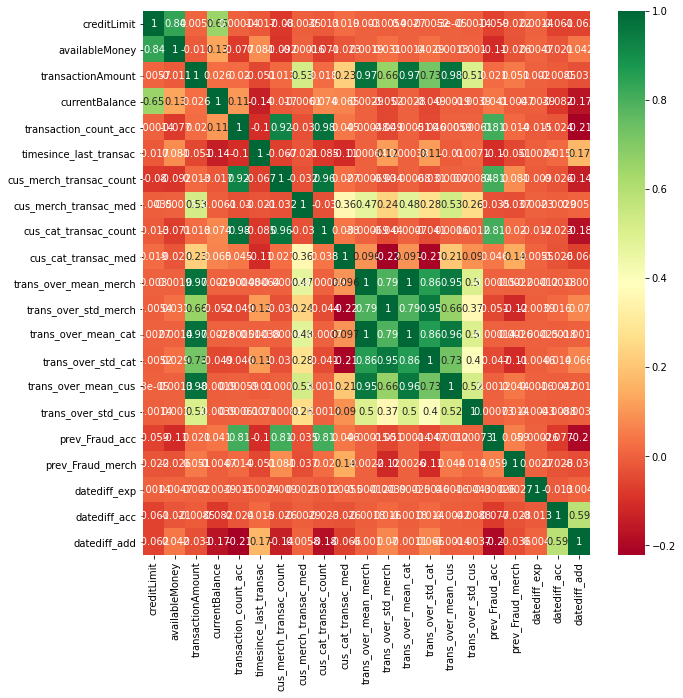

In [0]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numdf = df_model.select_dtypes(include=numerics)
df_model = df_model.drop(numdf.columns, axis=1)
corrmat = numdf.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
g=sns.heatmap(numdf[top_corr_features].corr(),annot=True,cmap="RdYlGn")

dropping highly correlated features:

1. Credit Limit: 2 features highly correlate it namely: availableMoney and currentBalance

2. transactionCountacc - this is a feature we developed but others highly correlated so dropping.

I let prev_Fraud_acc stay there on purpose as I feel, although they are correlated, it offers valuable information.

In [0]:
numdf = numdf.drop(["creditLimit", "transaction_count_acc"], axis=1)

At this point I can conduct PCA, but we have already removed correlated features so not conducting PCA

In [0]:
# from sklearn.decomposition import PCA
# numdf = numdf.drop(["creditLimit", "transaction_count_acc"], axis=1)
# pca = PCA(n_components=7)
# principalComponents = pca.fit_transform(numdf)
# numdf = pd.DataFrame(principalComponents, columns = ["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7"])
# numdf.head()


We can also do some Normalizing/scaling the columns with Robust Scaler (less prone to outliers) but skipping that as well.
The algorithms we use does not need normalizing, but normalizing will be done for autoencoder afterwards.
Normalizing at this point also impacted performance which has been tested.

In [0]:
# scaler = preprocessing.RobustScaler()
# numdf = pd.DataFrame(scaler.fit_transform(numdf), columns=numdf.columns, index=numdf.index)
# numdf.head()

In [0]:
df_model = pd.concat([numdf, df_model], axis=1)
df_model.head()

,availableMoney,transactionAmount,currentBalance,timesince_last_transac,cus_merch_transac_count,cus_merch_transac_med,cus_cat_transac_count,cus_cat_transac_med,trans_over_mean_merch,trans_over_std_merch,trans_over_mean_cat,trans_over_std_cat,trans_over_mean_cus,trans_over_std_cus,prev_Fraud_acc,prev_Fraud_merch,datediff_exp,datediff_acc,datediff_add,cardPresent,expirationDateKeyInMatch,isFraud,cvv_match,country_match,posEntryMode_,posEntryMode_02,posEntryMode_05,posEntryMode_09,posEntryMode_80,posEntryMode_90,posConditionCode_,posConditionCode_01,posConditionCode_08,posConditionCode_99
0,5000.0,98.55,0.0,2.0,0,98.55,0,98.55,0.676336,0.654610,0.673981,0.655354,2.096809,2.110799,0.0,512.0,82,17,17,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0
1,5000.0,74.51,0.0,58.0,0,74.51,0,74.51,0.514582,0.497311,0.510197,0.495961,1.585319,1.595897,0.0,20.0,88,19,19,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0
2,5000.0,7.47,0.0,28.0,0,7.47,0,7.47,1.273399,3.926232,1.279722,3.832968,0.158936,0.159997,0.0,0.0,106,20,20,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0
3,5000.0,7.47,0.0,31.0,1,7.47,1,7.47,1.273399,3.926232,1.279722,3.832968,0.158936,0.159997,0.0,0.0,105,21,21,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0
4,5000.0,71.18,0.0,2.0,0,71.18,0,71.18,0.515317,0.598171,0.488902,0.474981,0.663649,0.483884,0.0,1.0,164,7,7,1,0,0,1,1,0,1,0,0,0,0,0,1,0,0


In [0]:
df_model = df_model.replace([np.inf, -np.inf], np.nan)
df_model.fillna(0, inplace=True)

In [0]:
df_model.isnull().sum()

availableMoney              0
transactionAmount           0
currentBalance              0
timesince_last_transac      0
cus_merch_transac_count     0
cus_merch_transac_med       0
cus_cat_transac_count       0
cus_cat_transac_med         0
trans_over_mean_merch       0
trans_over_std_merch        0
trans_over_mean_cat         0
trans_over_std_cat          0
trans_over_mean_cus         0
trans_over_std_cus          0
prev_Fraud_acc              0
prev_Fraud_merch            0
datediff_exp                0
datediff_acc                0
datediff_add                0
cardPresent                 0
expirationDateKeyInMatch    0
isFraud                     0
cvv_match                   0
country_match               0
posEntryMode_               0
posEntryMode_02             0
posEntryMode_05             0
posEntryMode_09             0
posEntryMode_80             0
posEntryMode_90             0
posConditionCode_           0
posConditionCode_01         0
posConditionCode_08         0
posConditi

Using Traditional One Class ML algorithms first:
1. Isolation Forest
2. Local Outlier Factor

How much of the distribution data is outliers?

In [0]:
outlier_fraction = sum(df_model["isFraud"])/len(df_model)
outlier_fraction

0.01603611413419074

We make sure that out Train and test data has the right distributions of fraud and normal cases:

In [0]:
y = df_model['isFraud']
X = df_model.drop('isFraud', axis=1)


sss = StratifiedKFold(n_splits=5, random_state=321, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(y_train, return_counts=True)
test_unique_label, test_counts_label = np.unique(y_test, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(y_train))
print(test_counts_label/ len(y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Train: [145903 145909 145919 ... 745190 745191 745192] Test: [     0      1      2 ... 149169 149170 149171]
Train: [     0      1      2 ... 745190 745191 745192] Test: [145903 145909 145919 ... 298207 298208 298209]
Train: [     0      1      2 ... 745190 745191 745192] Test: [292670 292684 292697 ... 454094 454214 454235]
Train: [     0      1      2 ... 745190 745191 745192] Test: [447018 447019 447020 ... 599373 599578 599718]
Train: [     0      1      2 ... 599373 599578 599718] Test: [596116 596117 596118 ... 745190 745191 745192]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.9839639 0.0160361]
[0.98396382 0.01603618]


Trying ***Isolation forest Algorithm*** first


In [0]:
clf = IsolationForest(n_estimators=100, max_samples=int(len(df_model)*0.9), contamination=outlier_fraction,random_state=12, verbose=0)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_train[y_pred_train == 1] = 0
y_pred_train[y_pred_train == -1] = 1
y_pred_test = clf.predict(X_test)
y_pred_test[y_pred_test == 1] = 0
y_pred_test[y_pred_test == -1] = 1
print("Accuracy Score :")
print("For train set {} and for test set{}".format(accuracy_score(y_train,y_pred_train), accuracy_score(y_test,y_pred_test)))
print("Classification Report :")
print("For train set {} and for test set{}".format(classification_report(y_train,y_pred_train), classification_report(y_test,y_pred_test)))
print("For Train the confusion matrix is \n", confusion_matrix(y_train,y_pred_train, labels=[0,1]))
print("For test the confusion matrix is \n", confusion_matrix(y_test,y_pred_test, labels=[0,1]))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:281: UserWarning: max_samples (670673) is greater than the total number of samples (596155). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))


Accuracy Score :
For train set 0.9696454781055263 and for test set0.9735436600061729
Classification Report :
For train set               precision    recall  f1-score   support

           0       0.98      0.98      0.98    586595
           1       0.05      0.05      0.05      9560

    accuracy                           0.97    596155
   macro avg       0.52      0.52      0.52    596155
weighted avg       0.97      0.97      0.97    596155
 and for test set              precision    recall  f1-score   support

           0       0.98      0.99      0.99    146648
           1       0.04      0.03      0.03      2390

    accuracy                           0.97    149038
   macro avg       0.51      0.51      0.51    149038
weighted avg       0.97      0.97      0.97    149038

For Train the confusion matrix is 
 [[577547   9048]
 [  9048    512]]
For test the confusion matrix is 
 [[145026   1622]
 [  2321     69]]


The accuracy seems to be great, but our performance metrics should be Precision, Recall and F1 scores here.

Our F1 score for fraud detection is not good.

***Local outlier Factor***
please un-comment if you wish to test

In [0]:
# clf = LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
#                           leaf_size=30, metric='minkowski', novelty=True,
#                           p=2, metric_params=None, contamination=outlier_fraction, n_jobs=4)
# clf = clf.fit(X_train)

# y_pred_train = clf.predict(X_train)
# y_pred_train[y_pred_train == 1] = 0
# y_pred_train[y_pred_train == -1] = 1
# y_pred_test = clf.predict(X_test)
# y_pred_test[y_pred_test == 1] = 0
# y_pred_test[y_pred_test == -1] = 1
# print("Accuracy Score :")
# print("For train set {} and for test set{}".format(accuracy_score(y_train,y_pred_train), accuracy_score(y_test,y_pred_test)))
# print("Classification Report :")
# print("For train set {} and for test set{}".format(classification_report(y_train,y_pred_train), classification_report(y_test,y_pred_test)))
# print("For Train \n", confusion_matrix(y_train,y_pred_train, labels=[0,1]))
# print("For test \n", confusion_matrix(y_test,y_pred_test, labels=[0,1]))

We see similar trend with Local Outlier Factor.

Lets dive deeper into why that is happening and analyse our features. I will use dimentional reduction techniques to plot our data and see if the data is seperable. The methods I shall use are:

1. TSNE
2. PCA
3. TruncatedSVD

In [0]:
# getting total fraud transactions
len(df_model.loc[df_model['isFraud'] == 1])

In [0]:
df_model = df_model.sample(frac=1) # shuffling

# amount of fraud classes 11950 rows.
fraud_df = df_model.loc[df_model['isFraud'] == 1]
non_fraud_df = df_model.loc[df_model['isFraud'] == 0][:11950]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

# New_df is from the random undersample data (fewer instances)
X = new_df.drop('isFraud', axis=1)
y = new_df['isFraud']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

In [0]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

This clearly shows that the classes are not seperable with the features at hand, and seem completely randomized.

Therefore the ML methods are failing under the current features available.

Giving Deeplearning Method a try:

***Autoencoder***

In [0]:
# changing type to float and normalizing 
X_train = X_train.astype(float)
X_train = tf.keras.utils.normalize(X_train)
X_test = X_test.astype(float)
X_test = tf.keras.utils.normalize(X_test)

In [0]:
# designing the encoder-decoder architecture
input_dim = X_train.shape[1]
encoding_dim = 14
input_layer = tf.keras.layers.Input(shape=(input_dim, ))
encoder = tf.keras.layers.Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = tf.keras.layers.Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = tf.keras.layers.Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = tf.keras.layers.Dense(input_dim, activation='relu')(decoder)
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)

In [0]:
# running for only 3 epochs
nb_epoch = 3
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1).history

In [0]:
#saving the model for future use
autoencoder.save_weights('autoencoder.h5')

Looking at some plots:
1. Train test loss plot
2. ROC curve
3. Precision Recall Plot
4. Precision plot with threshold
5. Recall plot with threshold

In [0]:
# train test loss plot
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [0]:
# reconstruction error description

predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

In [0]:
# ROC curve
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [0]:
# Precision Recall plot
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [0]:
# Precision with threshold
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

In [0]:
# Recall  with threshold
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

Now we are setting our threshold by looking at the above plots and see how well it works

In [0]:
# different thresholds can be tested from here.

threshold = 0.00003
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [0]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=[0,1], yticklabels=[0,1], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

We can move the threshold to see how the confusion matrix changes.

Again, the visualization we see here shows that Fraud cases see unseprable from the normal cases given the features at hand. Given more time, qaulity features should be developed.